In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from os.path import isdir, join, isfile

In [4]:
import datetime
import pandas as pd
import seaborn as sns

In [14]:
dir_list = ["../data/tests_performance/N128_OMP16_32nodes_file_v10_1exec", 
            "../data/tests_performance/N128_OMP16_32nodes_file_v10",
            "../data/tests_performance/N128_OMP16_32nodes_file_v11", 
            "../data/tests_performance/N128_OMP16_32nodes_file_v12",
            "../data/tests_performance/N128_OMP16_32nodes_2node_v10_fast_sleep01",
            "../data/tests_performance/N128_OMP16_32nodes_2node_v11_fast_sleep01",
            "../data/tests_performance/N128_OMP16_32nodes_2node_v12_fast_sleep01",
            "../data/tests_performance/N128_OMP16_32nodes_3node_v10",
            "../data/tests_performance/N128_OMP16_32nodes_3node_v11",
            "../data/tests_performance/N128_OMP16_32nodes_3node_v12"]

dir_list = ["../data/tests_performance/N128_OMP16_32nodes_file_v10",
            "../data/tests_performance/N128_OMP16_32nodes_2node_v10_fast_sleep01",
            "../data/tests_performance/N128_OMP16_32nodes_3node_v10"]

logfile_list = []
for d in dir_list:
    print(d)
    logfile_list.append(join(d, "delta.log"))
    assert(isfile(logfile_list[-1]))
    assert(isdir(d))

../data/tests_performance/N128_OMP16_32nodes_file_v10
../data/tests_performance/N128_OMP16_32nodes_2node_v10_fast_sleep01
../data/tests_performance/N128_OMP16_32nodes_3node_v10


In [15]:
golden_ratio = 1.618

In [16]:
dframe_list = []
toff_list = []
for runnr, logfile in enumerate(logfile_list):
    dframe_pub = pd.DataFrame(columns = ["time_pub", "tidx"])
    dframe_con = pd.DataFrame(columns = ["time_con", "tidx"])

    with open(logfile, "r") as df:
        l0 = df.readline()
        splits = l0.split()
        # There is a , that needs to be removed
        fix_mus = splits[2].replace(",", ".", 1)
        fix_mus = fix_mus.replace(",", "")
        toff_run = datetime.datetime.strptime(splits[1] + " " + fix_mus, "%Y-%m-%d %H:%M:%S.%f") 

        
        for line in df:
            if not "processor_mpi_tasklist" in line:
                continue
                
                
            if "Published" in line:
                splits = line.split()
                fix_mus = splits[2].replace(",", ".", 1)
                fix_mus = fix_mus.replace(",", "")
                time_pub = datetime.datetime.strptime(splits[1] + " " + fix_mus, "%Y-%m-%d %H:%M:%S.%f") 
                tidx = int(splits[11])
                # Convert from time to offset from toff_run
                delta = time_pub - toff_run
                delta = delta.seconds + delta.microseconds * 1e-6
                new_row = {"tidx": tidx, "time_pub": delta}
                dframe_pub = dframe_pub.append(new_row, ignore_index=True)


            elif "Consumed" in line:
                splits = line.split()
                fix_mus = splits[2].replace(",", ".", 1)
                fix_mus = fix_mus.replace(",", "")
                time_con = datetime.datetime.strptime(splits[1] + " " + fix_mus, "%Y-%m-%d %H:%M:%S.%f") 
                delta = time_con - toff_run
                delta = delta.seconds + delta.microseconds * 1e-6
                tidx = int(splits[12][5:])

                new_row = {"tidx": tidx, "time_con": delta}
                dframe_con = dframe_con.append(new_row, ignore_index=True)    
                
    dframe = dframe_pub.merge(dframe_con, how="inner")
    #dframe["delta"] = dframe["time_con"] - dframe_run1["time_pub"]
    #dframe["delta_secs"] = dframe["delta"].apply(lambda x: x.seconds + x.microseconds * 1e-6)
    dframe_list.append(dframe)

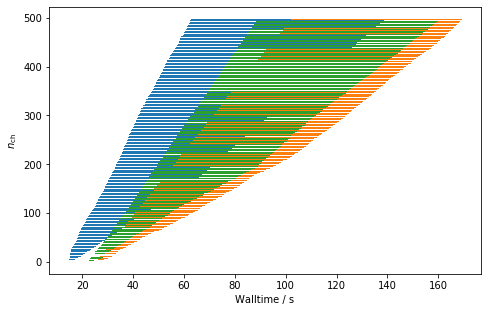

In [39]:
fig = plt.figure(figsize=(8, 8 / golden_ratio))
ax = fig.add_axes([0.2, 0.2, 0.75, 0.75])


for idx, dframe, dirname in zip([0, 1, 2], dframe_list, dir_list):
    for index, row in dframe.iterrows(): 
        if (index + idx) % 3 == 0:
            ax.plot([row["time_pub"],  row["time_con"]], [row["tidx"], row["tidx"]], f"C{idx:1d}-", lw=1)
#    ax.barh(y=row["tidx"], width=row["delta_secs"], left=offset, fc="C0", height=0.1)

    ax.set_xlabel(r"Walltime / s")
    ax.set_ylabel(r"$n_\mathrm{ch}$")
    #ax.set_title(dirname)


#    fig.savefig(f"{dirname}_performance_time_subcon.png", dpi=300)

In [28]:
f"{idx:1d}"

'0'